In [2]:
import sys
import os

# Add the folder to the Python path
folder_path = os.path.abspath('C:/Users/abel_/Documents/Lab/Projects/topological_diversity/Code/')
if folder_path not in sys.path:
    sys.path.append(folder_path)

In [271]:
import numpy as np
from itertools import product
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.integrate import solve_ivp

import seaborn as sns
from scipy.stats import gaussian_kde
import pandas as pd

import scipy.linalg
import matplotlib.animation as animation
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 1})

from ring_functions import *
from odes import *

output_path="C:/Users/abel_/Documents/Lab/Projects/topological_diversity/Stability/figures/plasticity/"

In [70]:
def combined_ode(t, vars, tau, W_asym, transfer_function, v_in, c_ff, N, sigma_W, lambda_W, damping_W=0, tau_W=1,
                  local=True, x_invman=[]):
    x = vars[:N]  # Extract x (first N elements)
    W_sym = vars[N:].reshape((N, N))  # Extract W (remaining elements)
    
    # Check shapes for debugging
    assert len(vars) == N + N**2, f"Expected length {N + N**2}, but got {len(vars)}"
    assert W_sym.shape == (N, N), f"Expected W_sym shape {(N, N)}, but got {W_sym.shape}"
    
    # Dynamics for x (original ODE)
    dxdt_novel = (-x + np.dot(W_sym, transfer_function(x)) / N + c_ff) / tau
    dxdt = (-x + np.dot(W_sym + v_in(t) * W_asym, transfer_function(x)) / N + c_ff) / tau
    
    # Dynamics for W (now W_ij = x_i * x_j)
    if local:
        dWdt = -lambda_W * np.outer(dxdt_novel, x)   # Outer product gives the dynamics \dot W_ij = \dot x_i * x_j

    else:
        dWdt = np.zeros((N, N))
        n_x_invman = len(x_invman)
        for x_inv_i in x_invman:
            dxdt_i = (-x_inv_i + np.dot(W_sym, transfer_function(x_inv_i)) / N + c_ff) / tau
            dWdt += - lambda_W*np.outer(dxdt_i, x_inv_i)/n_x_invman
    dWdt += -damping_W * W_sym
    dWdt /= tau_W


    eta_t = np.random.multivariate_normal(mean=np.zeros(N**2), cov=sigma_W).reshape((N, N))
    dWdt += eta_t
        
    return np.concatenate([dxdt, dWdt.flatten()])     # Flatten dWdt and append it to dxdt

def simulate_coupled_xW(y0s, W_sym0, b, W_asym, transfer_function=ReLU, v_in=v_zero, sigma_W=0, lambda_W=1, tau_W=1, damping_W=0,
                         local=True, x_invman=[],
                         tau=1, maxT=25, tsteps=501):
    N = W_sym0.shape[0]
    t = np.linspace(0, maxT, tsteps)
    sols_combined = np.zeros((y0s.shape[1], t.shape[0], N + N**2))

    for yi, y0 in enumerate(y0s.T):
        initial_conditions = np.concatenate([y0, W_sym0.flatten()])
        
        # Check the length of initial_conditions
        assert len(initial_conditions) == N + N**2, f"Expected length {N + N**2}, but got {len(initial_conditions)}"
        
        # Solve the combined system of ODEs (x and W)
        sol = solve_ivp(combined_ode, y0=initial_conditions, t_span=[0, maxT],
                        args=(tau, W_asym, transfer_function, v_in, b, N, sigma_W, lambda_W, damping_W, tau_W, local, x_invman),
                        dense_output=True)
        
        # Extract the solutions for x from the output
        sols_combined[yi, ...] = sol.sol(t)[:, :].T

    return sols_combined


def convert_to_angle(a_act, inits, pca):
    N = a_act.shape[-1]
    act_proj2 = pca.transform(a_act.reshape(-1, N))
    act_proj2 = act_proj2.reshape(a_act.shape[0], a_act.shape[1], 2)
    inits_proj2 = pca.transform(inits)
    decoded_angle = np.arctan2(act_proj2[:,:,1], act_proj2[:,:,0]) - np.arctan2(inits_proj2[:,1][:, np.newaxis], inits_proj2[:,0][:, np.newaxis])
    decoded_angle = np.unwrap(decoded_angle)
    return decoded_angle

noplast_color = "#e69f00"  # Light Amber 
noplast_av_color = "#a45f00"  # Darker shade of Amber

plast_color = "#1e90ff"  # Dodger Blue
plast_av_color = "#1257a5"  # Darker shade of Dodger Blue

int_vt_color = "#000000"  # Black


def run_experiment(scalar_sigma_W_values, lambda_W_values, vel_constant_list, tau_W_values, damping_W_values, W_epsilon_values,
                    local_values, x_invman, 
                    init_xs, W_sym, c_ff, W_asym, transfer_function=ReLU,  
                    tau=1, maxT=50, tsteps=501,
                    randomseed=1331, filename="simulation_results.csv"):
    N = W_sym.shape[0]
    data = [] # Initialize list to store results
    # Loop over parameter combinations

    all_params = list(product(scalar_sigma_W_values, lambda_W_values, vel_constant_list, tau_W_values, damping_W_values, W_epsilon_values, local_values))
    print("Number of experiments to run: ", len(all_params))
    for scalar_sigma_W, lambda_W, vel_constant, tau_W, damping_W, W_epsilon, local in tqdm(all_params):
        #print(f"Running simulation with scalar_sigma_W={scalar_sigma_W}, lambda_W={lambda_W}, vel_constant={vel_constant}, tau_W={tau_W}")
        v_in=v_constant(value=vel_constant)         # Set up input

        sigma_W = scalar_sigma_W * np.eye(N**2)     # Set up noise matrix
        np.random.seed(randomseed+int(vel_constant)+int(lambda_W)+int(1/(1e-3+scalar_sigma_W))) # Set random seed for reproducibility
        W_p = np.random.normal(0,W_epsilon,(N,N))

        np.random.seed(randomseed) # Set random seed for reproducibility
        # Run simulation
        sols = simulate_coupled_xW(
            y0s=init_xs[:].T,
            W_sym0=W_sym + W_p,
            b=c_ff,
            W_asym=W_asym,
            sigma_W=sigma_W,
            lambda_W=lambda_W,
            damping_W=damping_W,
            local=local,
            x_invman=x_invman,
            tau_W=tau_W,
            transfer_function=transfer_function,
            v_in=v_in,
            tau=tau,
            maxT=maxT,
            tsteps=tsteps
        )
        # Store results
        data.append({
            "scalar_sigma_W": scalar_sigma_W,
            "lambda_W": lambda_W,
            "vel_constant": vel_constant,
            "tau_W": tau_W,
            "damping_W": damping_W,
            "W_epsilon": W_epsilon,
            "local": local,
            "xt": sols[:,:,:N],
            "Wt": sols[:,:,N:]
        })

    df = pd.DataFrame(data)     # Convert to pandas DataFrame
    df.to_pickle(filename)      # Save to file
    return df

In [247]:
def plot_original_ra(ax, corners_proj2):
    for i in range(N):
        ax.plot([corners_proj2[i-1,0], corners_proj2[i,0]],
        [corners_proj2[i-1,1], corners_proj2[i,1]],
        'gray', zorder=-1, alpha=1, linewidth=5,
        solid_capstyle='round')


def find_invman_from_shortsim(y0s, W_sym, c_ff=1, maxT=5, tsteps=50):
    W_asym = np.zeros((N,N))
    invman = simulate_noorman_from_y0s(y0s, W_sym, W_asym, c_ff=1, maxT=maxT, tsteps=tsteps)[:,:,:].T
    y0s = np.copy(invman[:,2,:])

    #with spline based densefying
    # invman = invman[:,2,:]
    # invman_proj2 = pca.fit_transform(invman.reshape((-1,N)))
    # thetas_init = np.arctan2(invman_proj2[:,1], invman_proj2[:,0])
    # thetas = np.ravel(thetas_init)
    # idx = np.argsort(thetas)
    # thetas_sorted = thetas[idx]
    # thetas_sorted[-1] = np.pi
    # invman[:,-1] = invman[:,0]
    # cs = scipy.interpolate.CubicSpline(thetas_sorted, invman.T, bc_type='periodic')
    # invman = cs(thetas_uniform)
    # all_invmans.append(invman.T)
    # y0s = np.copy(invman.T)
    return invman

def find_fixed_points_and_stabilities(W_sym, c_ff, pca):
    fixed_points = noorman_fixed_points(W_sym, c_ff)
    fixed_points_proj2 = pca.transform(fixed_points) 
    
    for f_i, fixed_point_p in enumerate(fixed_points_proj2[:-1]):
        fixed_point = fixed_points[f_i]
        eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_point, W_sym))
        # if np.all(np.real(eigenvalues)<0):
        #     color = cmap_stab(norm(ti))  # Get color from colormap
        #     #ax.plot(fixed_point_p[0], fixed_point_p[1], '.', color=color, zorder=99, alpha=.5, markersize= markersize)
        # else:
        #     color = cmap_sadd(norm(ti))
        #     #ax.plot(fixed_point_p[0], fixed_point_p[1], '.', color=color, zorder=99, alpha=.5, markersize= markersize)
    return fixed_points, fixed_points_proj2, all_eigenvalues

def plot_fps_for_W(W, c_ff, pca, ax, ti, markersize = 12, cmap_stab = plt.cm.Greens, cmap_sadd = plt.cm.Oranges, norm = plt.Normalize(vmin=-501, vmax=501)):
    fixed_points, fixed_points_proj2, all_eigenvalues = find_fixed_points_and_stabilities(W, c_ff, pca)
    
    for f_i, fixed_point_p in enumerate(fixed_points_proj2[:-1]):
        fixed_point = fixed_points[f_i]
        eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_point, W_sym))
        if np.all(np.real(eigenvalues)<0):
            color = cmap_stab(norm(ti))  # Get color from colormap
            ax.plot(fixed_point_p[0], fixed_point_p[1], '.', color=color, zorder=99, alpha=.5, markersize= markersize)
        else:
            color = cmap_sadd(norm(ti))
            ax.plot(fixed_point_p[0], fixed_point_p[1], '.', color=color, zorder=99, alpha=.5, markersize= markersize)


def plot_fps_for_Wt(Wt, c_ff, pca, ax, markersize = 12, cmap_stab = plt.cm.Greens, cmap_sadd = plt.cm.Oranges, norm = plt.Normalize(vmin=-501, vmax=501)):
    all_fps = []
    all_eigenvalues = []
    for ti, W in tqdm(enumerate(Wt)):
        W = W.reshape((N,N))
        plot_fps_for_W(W, c_ff, pca, ax, ti, markersize = markersize, cmap_stab = cmap_stab, cmap_sadd = cmap_sadd, norm = norm)
    return all_fps, all_eigenvalues

def find_invman_through_sequence(y0s0, Wt, maxT=5, tsteps=50):
    y0s = np.copy(y0s0)
    all_invmans = []
    for i in range(Wt.shape[0]):
        W_sym = Wt[i].reshape((N,N))
        invman = find_invman_from_shortsim(y0s, W_sym, c_ff=1, maxT=maxT, tsteps=tsteps)
        all_invmans.append(invman)

    return all_invmans

def vf_along_invman(invman, W_sym, c_ff):
    vf = np.zeros((invman.shape[0], N))
    for i in range(invman.shape[0]):
        vf[i,:] = noorman_ode(0, invman[i], tau, transfer_function, W_sym, W_asym, c_ff, N, v_zero)

    vf_proj2 = pca.transform(vf.reshape(-1, N))
    return vf, vf_proj2


def calc_kde(data, xmin=-3.2, xmax=3.2, ymin=-3.2, ymax=3.2):
    # data.shape = (n, 2)
    x = data[:,0]
    y = data[:,1]
    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    return f, xx, yy

In [53]:
# loaded_object = pickle.load(open('simulation_results.pickle', 'rb'))


In [168]:
N, J_I, J_E, c_ff, tau = 6, -2.4, 4, 1, 1
transfer_function, v_in = ReLU, v_zero
W_sym = get_noorman_symmetric_weights(N, J_I, J_E)
W_asym = get_noorman_asymmetric_weights(N)

maxT, tsteps = 50, 501
t = np.linspace(0, maxT, tsteps)

y0 = np.random.uniform(0,1,N)
sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N, v_in]),dense_output=True)
m = np.max(sol.sol(t)) 
corners = get_corners(N, m)
bump_step_size = .01
side_bumps = get_bumps_along_oneside_ring(N, m, corners, step_size=bump_step_size)
all_bumps = get_all_bumps(N, side_bumps)
pca = sklearn.decomposition.PCA(n_components=2)
X_proj2 = pca.fit_transform(all_bumps.reshape(-1, N)) 
corners_proj2 = pca.transform(corners)
all_bumps.shape

(762, 6)

In [169]:
######### plasticity effect experiment
scalar_sigma_W_values = [.5, 0.1, 0.01, 0.001]
lambda_W_values = [1]
vel_constant_list = [0, -.5]
tau_W_values = [.5, .25]
damping_W_values = [0]
W_epsilon_values = [0]

df = run_experiment(scalar_sigma_W_values, lambda_W_values, vel_constant_list, tau_W_values, damping_W_values, W_epsilon_values,
                    all_bumps, W_sym, c_ff, W_asym, transfer_function=transfer_function,  
                    tau=tau, maxT=maxT, tsteps=tsteps,
                    randomseed=1331, filename="outer_tauW.pickle")


#antifragility experiment
# W_epsilon = .1
# scalar_sigma_W_values = [0, 0.00001]
# lambda_W_values = [0, 1]
# vel_constant_list = [0]
    
# df_af = run_experiment(scalar_sigma_W_values, lambda_W_values, vel_constant_list,
#                     all_bumps, W_sym, W_epsilon, c_ff, W_asym, transfer_function=ReLU,  
#                     tau=tau, maxT=maxT, tsteps=tsteps,
#                     randomseed=1331, filename="antifragility_results.pickle")

TypeError: run_experiment() missing 2 required positional arguments: 'c_ff' and 'W_asym'

## Local vs global plasticity 

In [377]:
output_path="C:/Users/abel_/Documents/Lab/Projects/topological_diversity/Stability/figures/plasticity/glovsloc/"

#find inv man after initial pertubration for global learning rule
randomseed = 1331
W_epsilon = .25
np.random.seed(randomseed+int(0)+1+int(1/(1e-3+.0))) # 
W_p = np.random.normal(0,W_epsilon,(N,N))

pert_sols = simulate_noorman_from_y0s(all_bumps[:].T, W_sym+W_p, W_asym, c_ff=1, maxT=maxT, tsteps=tsteps)
pert_sols_proj2 = pca.transform(pert_sols.reshape(-1, N)).reshape(pert_sols.shape[0], pert_sols.shape[1], 2)

(-5.0, 5.0)

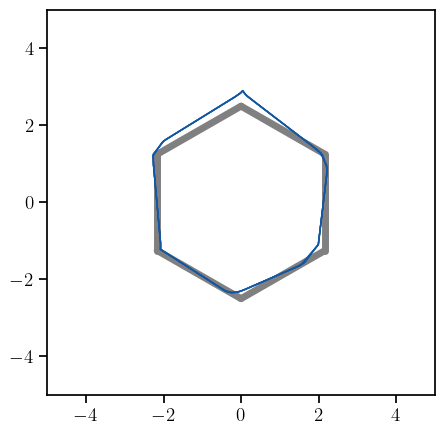

In [378]:
after_t = 50
before_t = 60

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(pert_sols_proj2[:,after_t:before_t,0], pert_sols_proj2[:,after_t:before_t,1], '-', color=plast_av_color, alpha=.5);

plot_original_ra(ax, corners_proj2)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

In [402]:
scalar_sigma_W_values = [.0]
lambda_W_values = [1]
vel_constant_list = [0]
tau_W_values = [1]
damping_W_values = [0]
W_epsilon_values = [W_epsilon]
local_values = [True, False]

maxT, tsteps = 500, 5001
t = np.linspace(0, maxT, tsteps)
from_og = False
if from_og:
    ref_invman = all_bumps
else: 
    ref_invman = pert_sols[:,after_t,:]

df = run_experiment(scalar_sigma_W_values, lambda_W_values, vel_constant_list, tau_W_values, damping_W_values, W_epsilon_values,
                    local_values, all_bumps, #pert_sols[:,after_t,:],
                    all_bumps[:1], W_sym, c_ff, W_asym, transfer_function=transfer_function,  
                    tau=tau, maxT=maxT, tsteps=tsteps,
                    randomseed=randomseed, filename="large_pert.pickle")

Number of experiments to run:  2


100%|██████████| 2/2 [00:04<00:00,  2.33s/it]


In [403]:
sols_local = df[(df['local'] == True)].iloc[0]["xt"]
sols_global = df[(df['local'] == False)].iloc[0]["xt"]

weights_local = df[(df['local'] == True)].iloc[0]["Wt"]
weights_global = df[(df['local'] == False)].iloc[0]["Wt"]

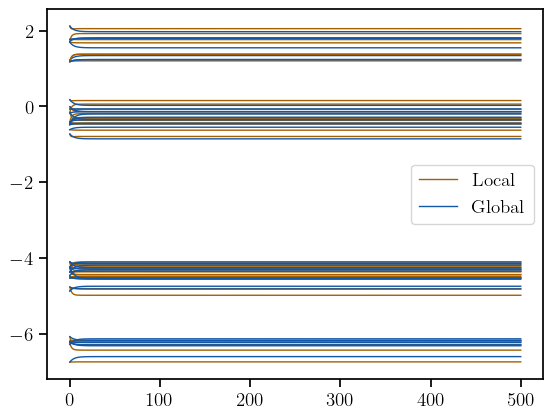

In [404]:
import matplotlib.pyplot as plt

# Plot all local solutions, but extract only the first line for legend
lines_local = plt.plot(t, weights_local[0, :, :], color=noplast_av_color)

# Plot all global solutions, but extract only the first line for legend
lines_global = plt.plot(t, weights_global[0, :, :], color=plast_av_color)

line1, = plt.plot(t, weights_local[0, :, 0], color=noplast_av_color, label="Local")  # First column only
line2, = plt.plot(t, weights_global[0, :, 0], color=plast_av_color, label="Global")  # First column only

# Display legend
plt.legend(handles=[line1, line2])
if from_og:
    plt.savefig(f'{output_path}/singlepert_fromog_weights_Wepsilon_{W_epsilon}_tauW{tau_W_values[0]}_damping{damping_W_values[0]}_rs{randomseed}.pdf')
else:
    plt.savefig(f'{output_path}/singlepert_fromnewim_weights_Wepsilon_{W_epsilon}_tauW{tau_W_values[0]}_damping{damping_W_values[0]}_rs{randomseed}.pdf')
plt.show()

In [405]:
bump_step_size = .1
side_bumps = get_bumps_along_oneside_ring(N, m, corners, step_size=bump_step_size)
all_bumps = get_all_bumps(N, side_bumps)

W_global_after = weights_global[0,-1,:].reshape(N,N)
after_global_sols = simulate_noorman_from_y0s(all_bumps[:].T, W_global_after, W_asym, c_ff=1, maxT=maxT, tsteps=tsteps)
after_global_sols_proj2 = pca.transform(after_global_sols.reshape(-1, N)).reshape(after_global_sols.shape[0], after_global_sols.shape[1], 2)

W_local_after = weights_local[0,-1,:].reshape(N,N)
after_local_sols = simulate_noorman_from_y0s(all_bumps[:].T, W_local_after, W_asym, c_ff=1, maxT=maxT, tsteps=tsteps)
after_local_sols_proj2 = pca.transform(after_local_sols.reshape(-1, N)).reshape(after_local_sols.shape[0], after_local_sols.shape[1], 2)

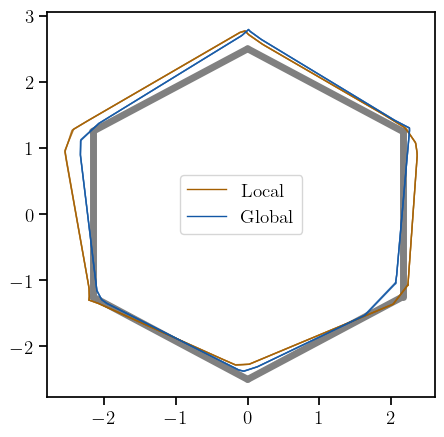

In [415]:
after_t = 50
before_t = after_t+5

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(after_local_sols_proj2[:,after_t:before_t,0], after_local_sols_proj2[:,after_t:before_t,1], '-', color=noplast_av_color, alpha=.5);
plt.plot(after_global_sols_proj2[:,after_t:before_t,0], after_global_sols_proj2[:,after_t:before_t,1], '-', color=plast_av_color, alpha=.5);

plt.legend(handles=[line1, line2])

plot_original_ra(ax, corners_proj2)

In [416]:
invman_global = after_global_sols[:,after_t,:]
invman_local = after_local_sols[:,after_t,:]
invman_global_proj2 = after_global_sols_proj2[:,after_t,:]
invman_local_proj2 = after_local_sols_proj2[:,after_t,:]
vf_global, vf_global_proj2 = vf_along_invman(invman_global, W_global_after, c_ff)
vf_local, vf_local_proj2 = vf_along_invman(invman_local, W_local_after, c_ff)

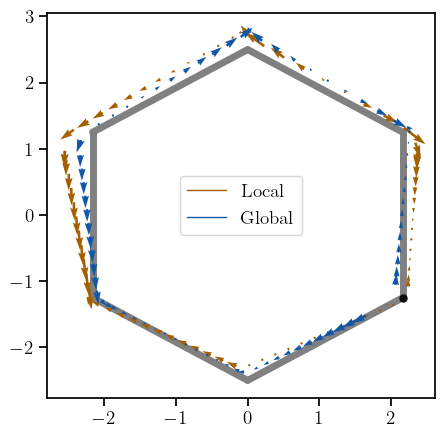

In [417]:
fig, ax = plt.subplots(figsize=(5, 5))
quiver_scale=2
plt.plot(after_local_sols_proj2[0,0,0], after_local_sols_proj2[0,0,1], '.', color='#0c0c0c', alpha=1, markersize=10);
plt.quiver(invman_local_proj2[:,0], invman_local_proj2[:,1], vf_local_proj2[:,0], vf_local_proj2[:,1], scale=quiver_scale, color=noplast_av_color)
plt.quiver(invman_global_proj2[:,0], invman_global_proj2[:,1], vf_global_proj2[:,0], vf_global_proj2[:,1], scale=quiver_scale, color=plast_av_color)
plt.legend(handles=[line1, line2])
plot_original_ra(ax, corners_proj2)

if from_og:
    plt.savefig(f'{output_path}/singlepert_vf_fromog_Wepsilon_{W_epsilon}_tauW{tau_W_values[0]}_damping{damping_W_values[0]}_rs{randomseed}.pdf', bbox_inches='tight')
    plt.savefig(f'{output_path}/singlepert_vf_fromog_Wepsilon_{W_epsilon}_tauW{tau_W_values[0]}_damping{damping_W_values[0]}_rs{randomseed}.png', bbox_inches='tight')
else:
    plt.savefig(f'{output_path}/singlepert_vf_fromnewim_Wepsilon_{W_epsilon}_tauW{tau_W_values[0]}_damping{damping_W_values[0]}_rs{randomseed}.pdf', bbox_inches='tight')
    plt.savefig(f'{output_path}/singlepert_vf_fromnewim_Wepsilon_{W_epsilon}_tauW{tau_W_values[0]}_damping{damping_W_values[0]}_rs{randomseed}.png', bbox_inches='tight')

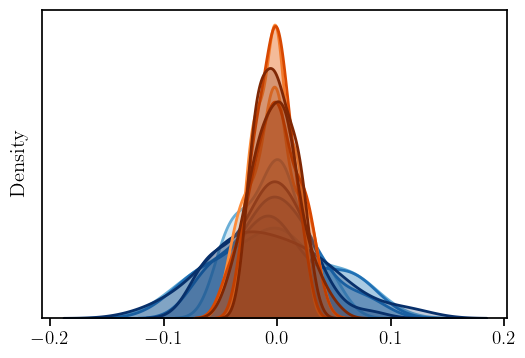

In [49]:
#plot final distribution of angles for vel_constant=0 (no input)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.patches as mpatches

# Assuming scalar_sigma_W_values and lambda_W_values are lists and df is your DataFrame

# Create the plot
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))

# Define colormaps for plasticity and no plasticity
color_map_plast = plt.cm.Oranges(np.linspace(0.5, 1, len(scalar_sigma_W_values)))  # Warmer colors for plasticity
color_map_noplast = plt.cm.Blues(np.linspace(0.5, 1, len(scalar_sigma_W_values)))  # Cooler colors for no plasticity

legend_patches_plasticity = []  # Store legend patches for plasticity
legend_patches_noplasticity = []  # Store legend patches for no plasticity

# Loop over lambda_W values
vel_constant = 0
for lambda_W in lambda_W_values:
    color_map = color_map_noplast if lambda_W == 0 else color_map_plast
    
    for i, scalar_sigma_W in enumerate(sorted(scalar_sigma_W_values)):
        for tau_W in tau_W_values:
            df_ = df[(df['scalar_sigma_W'] == scalar_sigma_W) & 
                    (df['lambda_W'] == lambda_W) & 
                    (df['vel_constant'] == vel_constant) &
                    (df['tau_W'] == tau_W)]  # No input condition
            
            if df_.empty:
                continue  # Skip if no data
            
            array = df_.iloc[0]["xt"]
            final_angles = convert_to_angle(array, all_bumps, pca)[:,-1] # - vel_constant*t[-1]/4
            
            color = color_map[i]  # Select color based on index
            
            label = f"$\sigma_W$={scalar_sigma_W}, " + ("Plasticity" if lambda_W == 1 else "No Plasticity")
            
            sns.kdeplot(x=final_angles, ax=ax1, color=color, label=label, fill=True, linewidth=2)

            # Store for the legend
            patch = mpatches.Patch(color=color, label=f"$\sigma_W$={scalar_sigma_W}")
            if lambda_W == 1:
                legend_patches_plasticity.append(patch)
            else:
                legend_patches_noplasticity.append(patch)

# Show the main plot
#ax1.legend(ncol=2)
ax1.set_yticks([])
#ax1.set_xlim(-np.pi, np.pi)
# plt.savefig(f'{output_path}/noise_levels.png', bbox_inches='tight', dpi=500)
# plt.savefig(f'{output_path}/noise_levels.pdf', bbox_inches='tight', dpi=500)
plt.show()

5.0

In [889]:
def plot_plasticity_effects(sols_noplast, sols_plast, scalar_sigma_W, vel_constant, t, tsteps, maxT, all_bumps, pca,
                            noplast_color, plast_color, noplast_av_color, plast_av_color, output_path,
                            ylim=(-np.pi/10, np.pi/10)):

    int_vt = -t * vel_constant / 4
    decoded_angle_noplast = convert_to_angle(sols_noplast, all_bumps, pca) - int_vt
    decoded_angle_plast = convert_to_angle(sols_plast, all_bumps, pca) - int_vt
    t_actual = t / (tsteps - 1) * maxT
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True, width_ratios=[3, 1])
    
    for i in range(decoded_angle_noplast.shape[0]):
        ax1.plot(t_actual, decoded_angle_noplast[i], color=noplast_color, alpha=0.5, linewidth=2)
        ax1.plot(t_actual, decoded_angle_plast[i], color=plast_color, alpha=0.5, linewidth=2, zorder=0)
    
    ax1.plot(t_actual, np.mean(decoded_angle_noplast, axis=0), color=noplast_av_color, linewidth=3, label='No plasticity avg')
    ax1.plot(t_actual, np.mean(decoded_angle_plast, axis=0), color=plast_av_color, linewidth=3, label='Plasticity avg')
    ax1.set(title='Decoded angle', xlabel='Time (s)', ylabel='Integrated angular velocity (rad)')
    ax1.grid(True)
    ax1.set_ylim(ylim)
    
    # kde plot for final angles
    final_noplast = decoded_angle_noplast[:, -1]
    final_plast = decoded_angle_plast[:, -1]
    sns.kdeplot(y=final_noplast, ax=ax2, color=noplast_color, fill=True, linewidth=2)
    sns.kdeplot(y=final_plast, ax=ax2, color=plast_color, fill=True, linewidth=2)
    ax2.set(title='Final angles', xlabel='Density', ylabel='Final Decoded Angle (rad)')
    ax2.grid(True)
    ax2.set_xticks([])
    ax2.set_ylim(ylim)
    
    ax1.legend(loc='lower right', fontsize=10)
    #ax2.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'{output_path}/outerplasteffect_decangle_dens_zoom_vel{vel_constant}_sigmaW{scalar_sigma_W}.png', bbox_inches='tight', dpi=500)
    plt.savefig(f'{output_path}/outerplasteffect_decangle_dens_zoom_vel{vel_constant}_sigmaW{scalar_sigma_W}.pdf', bbox_inches='tight', dpi=500)
    plt.show()


def plot_antifragility_effects(sols_nonoise, sols_noise, scalar_sigma_W, vel_constant, t, tsteps, maxT, all_bumps, pca,
                            noplast_color, plast_color, noplast_av_color, plast_av_color, output_path,
                            ylim=(-np.pi/10, np.pi/10)):
    int_vt = -t * vel_constant / 4
    decoded_angle_nonoise = convert_to_angle(sols_nonoise, all_bumps, pca) - int_vt
    decoded_angle_noise = convert_to_angle(sols_noise, all_bumps, pca) - int_vt
    t_actual = t / (tsteps - 1) * maxT
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True, width_ratios=[3, 1])
    
    for i in range(decoded_angle_nonoise.shape[0]):
        ax1.plot(t_actual, decoded_angle_nonoise[i], color=noplast_color, alpha=0.5, linewidth=2)
        ax1.plot(t_actual, decoded_angle_noise[i], color=plast_color, alpha=0.5, linewidth=2, zorder=0)
    
    ax1.plot(t_actual, np.mean(decoded_angle_nonoise, axis=0), color=noplast_av_color, linewidth=3, label='No weight noise')
    ax1.plot(t_actual, np.mean(decoded_angle_noise, axis=0), color=plast_av_color, linewidth=3, label='Weight noise')
    ax1.set(title='Decoded angle', xlabel='Time (s)', ylabel='Integrated angular velocity (rad)')
    ax1.grid(True)
    ax1.set_ylim(ylim)
    
    # kde plot for final angles
    final_noplast = decoded_angle_nonoise[:, -1]
    final_plast = decoded_angle_noise[:, -1]
    sns.kdeplot(y=final_noplast, ax=ax2, color=noplast_color, fill=True, linewidth=2)
    sns.kdeplot(y=final_plast, ax=ax2, color=plast_color, fill=True, linewidth=2)
    ax2.set(title='Final angles', xlabel='Density', ylabel='Final Decoded Angle (rad)')
    ax2.grid(True)
    ax2.set_xticks([])
    ax2.set_ylim(ylim)
    
    ax1.legend(loc='lower right', fontsize=10)
    #ax2.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'{output_path}/af_decangle_dens_zoom_vel{vel_constant}_sigmaW{scalar_sigma_W}.png', bbox_inches='tight', dpi=500)
    plt.savefig(f'{output_path}/af_decangle_dens_zoom_vel{vel_constant}_sigmaW{scalar_sigma_W}.pdf', bbox_inches='tight', dpi=500)
    plt.show()

In [ ]:
for scalar_sigma_W in scalar_sigma_W_values:
    for vel_constant in vel_constant_list:
        sols_noplast = df[(df['scalar_sigma_W'] == scalar_sigma_W) & (df['lambda_W'] == 0) & (df['vel_constant'] == vel_constant)].iloc[0]["xt"]
        sols_plast = df[(df['scalar_sigma_W'] == scalar_sigma_W) & (df['lambda_W'] == 1) & (df['vel_constant'] == vel_constant)].iloc[0]["xt"]
        
        plot_plasticity_effects(sols_noplast, sols_plast, scalar_sigma_W, vel_constant, t, tsteps, maxT, all_bumps, pca,
                            noplast_color, plast_color, noplast_av_color, plast_av_color, output_path)

In [ ]:
# effect of noise on recovery from big perturbation

sols_nonoise = df_af[(df_af['scalar_sigma_W'] == 0.) & (df_af['lambda_W'] == 1) & (df_af['vel_constant'] == 0)].iloc[0]["xt"]
sols_noise = df_af[(df_af['scalar_sigma_W'] == df_af['scalar_sigma_W'].unique()[-1]) & (df_af['lambda_W'] == 1) & (df_af['vel_constant'] == 0)].iloc[0]["xt"]
        
plot_antifragility_effects(sols_nonoise, sols_noise, scalar_sigma_W, 0, t, tsteps, maxT, all_bumps, pca,
                            noplast_color, plast_color, noplast_av_color, plast_av_color, output_path,
                            ylim=(-np.pi/50, np.pi/50))

In [ ]:
#shifting invariant manfiold: tracking FPs 
invman_0 = all_bumps
thetas_uniform = np.linspace(-np.pi, np.pi, all_bumps.shape[0])
all_invmans = [invman_0.T]
y0s = invman_0.T
maxT = 5
tsteps = 51

#Wt = loaded_object[(loaded_object['scalar_sigma_W'] == 0.1) & (loaded_object['lambda_W'] == 0) & (loaded_object['vel_constant'] == 0)].iloc[0]["Wt"]
#fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#plot_fps_for_Wt(Wt[0][1::50], c_ff, pca, ax, markersize = 12, cmap_stab = plt.cm.Greens, cmap_sadd = plt.cm.Oranges, norm = plt.Normalize(vmin=-501, vmax=501))
vel_constant = 0
scalar_sigma_W = 0.001
Wt_no = loaded_object[(loaded_object['scalar_sigma_W'] == scalar_sigma_W) & (loaded_object['lambda_W'] == 0) & (loaded_object['vel_constant'] == vel_constant)].iloc[0]["Wt"]
Wt_plast = loaded_object[(loaded_object['scalar_sigma_W'] == scalar_sigma_W) & (loaded_object['lambda_W'] == 1) & (loaded_object['vel_constant'] == vel_constant)].iloc[0]["Wt"]

over_all_invmans_no = []
over_all_invmans_plast = []
for idx in tqdm(range(Wt_no.shape[0])):
    all_invmans_no = find_invman_through_sequence(y0s, Wt_no[idx][-1:], maxT=maxT, tsteps=tsteps)
    over_all_invmans_no.append(all_invmans_no)
    all_invmans_plast = find_invman_through_sequence(y0s, Wt_plast[idx][-1:], maxT=maxT, tsteps=tsteps)
    over_all_invmans_plast.append(all_invmans_plast)

100%|██████████| 48/48 [01:52<00:00,  2.34s/it]


In [314]:
over_all_invmans_no_proj2 = []
over_all_norms_no = []
for idx, all_invmans_no in enumerate(over_all_invmans_no):
    invman_no = all_invmans_no[-1][:,15,:].T
    all_invmans_no_proj2 = pca.transform(invman_no)
    over_all_invmans_no_proj2.append(all_invmans_no_proj2)
    W = Wt_no[idx][-1:].reshape((N,N))
    vf, vf_proj2 = vf_along_invman(invman_no, W, c_ff=1)
    over_all_norms_no.append(np.linalg.norm(vf, axis=1))
    #plt.plot(all_invmans_no_proj2[:,0], all_invmans_no_proj2[:,1], color=noplast_color, alpha=.1, markersize=1, label="No plasticity")
over_all_invmans_no_proj2 = np.array(over_all_invmans_no_proj2).reshape(-1,2)
over_all_norms_no = np.array(over_all_norms_no)
#sns.kdeplot(over_all_invmans_no_proj2, ax=ax, color=noplast_color, fill=True, linewidth=2)

over_all_invmans_plast_proj2 = []
over_all_norms_plast = []
for all_invmans_plast in over_all_invmans_plast:
    invman_plast = all_invmans_plast[-1][:,15,:].T
    all_invmans_plast_proj2 = pca.transform(invman_plast)
    over_all_invmans_plast_proj2.append(all_invmans_plast_proj2)
    W = Wt_plast[idx][-1:].reshape((N,N))
    vf, vf_proj2 = vf_along_invman(invman_plast, W, c_ff=1)
    over_all_norms_plast.append(np.linalg.norm(vf, axis=1))
    #plt.plot(all_invmans_plast_proj2[:,0], all_invmans_plast_proj2[:,1], color=plast_color, alpha=.1, markersize=1, label="Plasticity")
over_all_invmans_plast_proj2 = np.array(over_all_invmans_plast_proj2).reshape(-1,2)   
over_all_norms_plast = np.array(over_all_norms_plast)

#ax.legend()

In [260]:
f_no, xx, yy = calc_kde(over_all_invmans_no_proj2)
f_plast, xx, yy = calc_kde(over_all_invmans_plast_proj2)

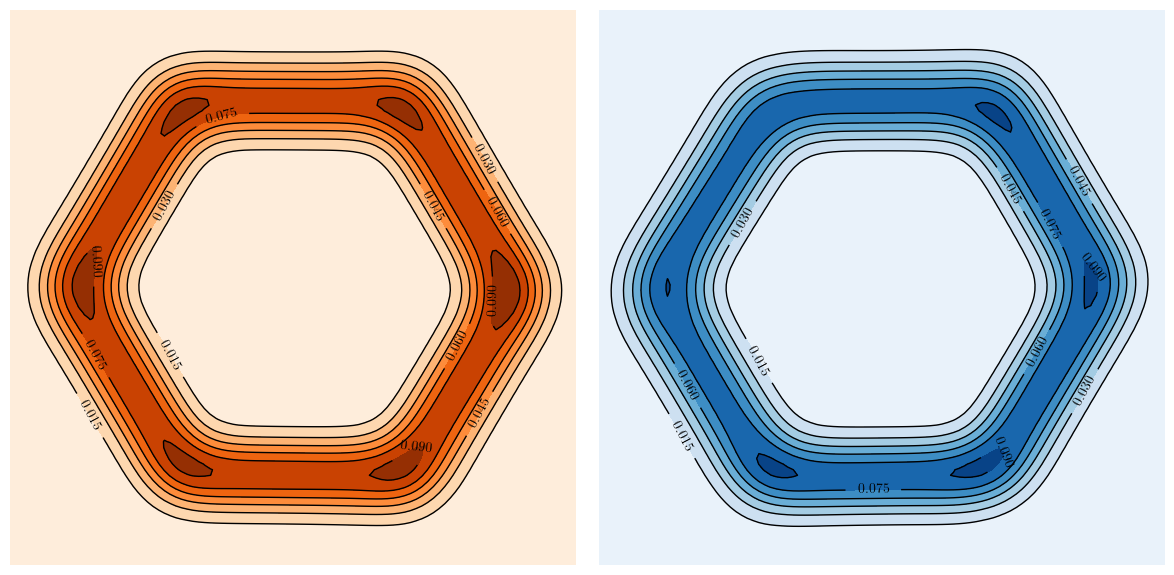

In [ ]:
import scipy.stats as st
xmin, xmax = -3.2, 3.2
ymin, ymax = -3.2, 3.2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
for i in range(N):
    ax.plot([corners_proj2[i-1,0], corners_proj2[i,0]],
    [corners_proj2[i-1,1], corners_proj2[i,1]],
    'gray', zorder=-1, alpha=1, linewidth=5,
    solid_capstyle='round')

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)
# Contourf plot
cfset_no = ax1.contourf(xx, yy, f_no, cmap='Oranges')
cset_no = ax1.contour(xx, yy, f_no, colors='k')
cfset_plast = ax2.contourf(xx, yy, f_plast, cmap='Blues')
cset_plast = ax2.contour(xx, yy, f_plast, colors='k')
# Label plot
ax1.clabel(cset_no, inline=1, fontsize=10)
ax2.clabel(cset_plast, inline=1, fontsize=10)
ax1.set_axis_off()
ax2.set_axis_off()
plt.tight_layout()
plt.savefig(f'{output_path}/outerplasteffect_kde_vel{vel_constant}_sigmaW{scalar_sigma_W}.png', bbox_inches='tight', dpi=500)

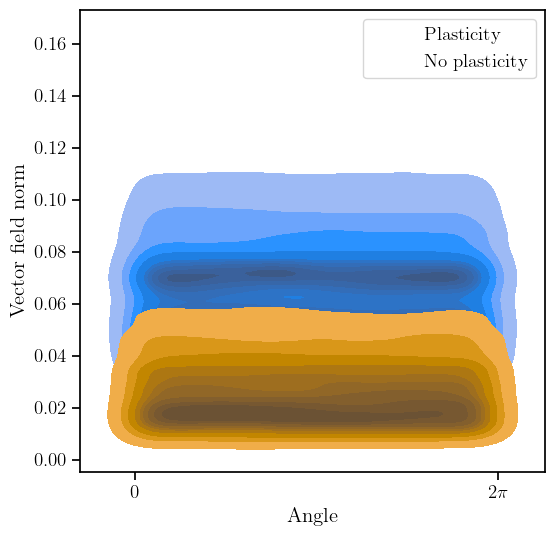

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#ax.set_xticks(range(48), np.linspace(0,2*np.pi,48))

sns.kdeplot(x=[i for i in range(48)]*762, y=over_all_norms_plast.flatten(), ax=ax, color=plast_color, fill=True, label="Plasticity");
sns.kdeplot(x=[i for i in range(48)]*762, y=over_all_norms_no.flatten(), ax=ax, color=noplast_color, fill=True, label="No plasticity");
ax.set_xticks([0,48], [0, r"$2\pi$"])
ax.set_xlabel("Angle")
ax.set_ylabel("Vector field norm")

ax.legend()
plt.savefig(f'{output_path}/outerplasteffect_norms_vel{vel_constant}_sigmaW{scalar_sigma_W}.png', bbox_inches='tight', dpi=500)
plt.savefig(f'{output_path}/outerplasteffect_norms_vel{vel_constant}_sigmaW{scalar_sigma_W}.pdf', bbox_inches='tight', dpi=500)

In [316]:
over_all_norms_plast.mean(), over_all_norms_no.mean()   

(0.0626954736308487, 0.027540235944099645)

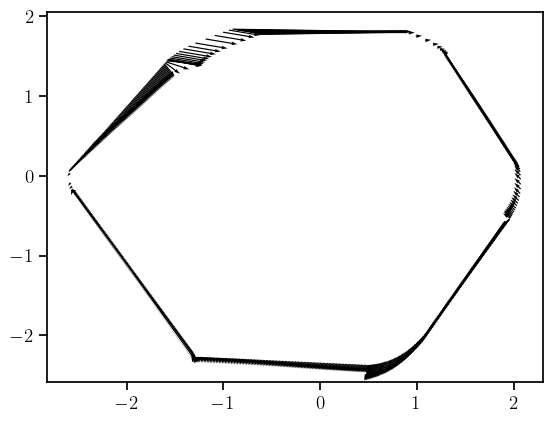

In [317]:
plt.quiver(invmans_no_proj2[:,0], invmans_no_proj2[:,1], vf_proj2[:,0], vf_proj2[:,1], scale=1)

In [272]:
vf_proj2.shape

(762, 2)

In [802]:
def make_fps_video(Wt, filename='fixed_points_evolution'):
    frames = len(Wt) - 1  # Number of frames

    # Define parameters
    markersize = 50
    cmap_stab = plt.cm.Greens  # Colormap for stable fixed points
    cmap_sadd = plt.cm.Oranges  # Colormap for saddle fixed points
    norm = plt.Normalize(vmin=-501, vmax=501)  # Normalize ti values

    # Create figure
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim([-3, 3])  # Adjust as per your PCA-transformed space
    ax.set_ylim([-3, 3])
    ax.set_title("Fixed Points Evolution")
    all_fps = []
    all_eigenvalues = []
    scatters = []
    
    def update(ti):
        
        """Function to update each frame"""
        ax.clear()
        ax.set_xlim([-3, 3])
        ax.set_ylim([-3, 3])
        ax.set_title(f"Fixed Points at Time {ti}")

        W_sym = Wt[ti + 1].reshape((N, N))  # Extract weight matrix
        fixed_points = noorman_fixed_points(W_sym, c_ff)
        fixed_points_proj2 = pca.transform(fixed_points)

        # Store fixed points
        all_fps.append(fixed_points_proj2)
        
        stable_points = []
        unstable_points = []
        
        for f_i, fixed_point_p in enumerate(fixed_points_proj2[:-1]):
            fixed_point = fixed_points[f_i]
            eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_point, W_sym))
            all_eigenvalues.append(eigenvalues)

            # Classify based on eigenvalues
            if np.all(np.real(eigenvalues) < 0):
                stable_points.append(fixed_point_p)
                ax.scatter(fixed_point_p[0], fixed_point_p[1], 
                    color=cmap_stab(norm(300)), alpha=1, s=markersize, label="Stable")
            else:
                unstable_points.append(fixed_point_p)
                ax.scatter(fixed_point_p[0], fixed_point_p[1], 
                    color=cmap_sadd(norm(300)), alpha=1, s=markersize, label="Saddle")
                
        for i in range(N):
            ax.plot([corners_proj2[i-1,0], corners_proj2[i,0]],
                [corners_proj2[i-1,1], corners_proj2[i,1]],
                'gray', label="Original attractor", zorder=-1, alpha=1, linewidth=5, 
                solid_capstyle='round')
        
        ax.set_xticks([])
        ax.set_yticks([])
        #remove frame around the plot 
        for spine in ax.spines.values():
            spine.set_visible(False)

    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=frames, interval=frames)  # Adjust interval for speed

    # Save as video file
    ani.save(filename+".mp4", writer="ffmpeg", fps=30)  # Save as MP4
    ani.save(filename+".gif", writer="pillow", fps=30)  # Save as GIF if needed

In [ ]:


corners_proj2 = pca.transform(corners)

for j in range(Wt_noplast.shape[0]):
    Wt_i = Wt_noplast[j]
    make_fps_video(Wt_i, filename=f'noplas_fps_evolution_{j}')


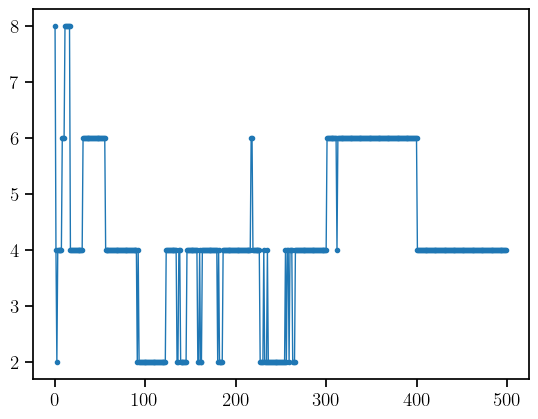

In [ ]:
#get the number of rows in each item in all_fps
n_fps = [len(i)-1 for i in all_fps]
plt.plot(n_fps, '.-')

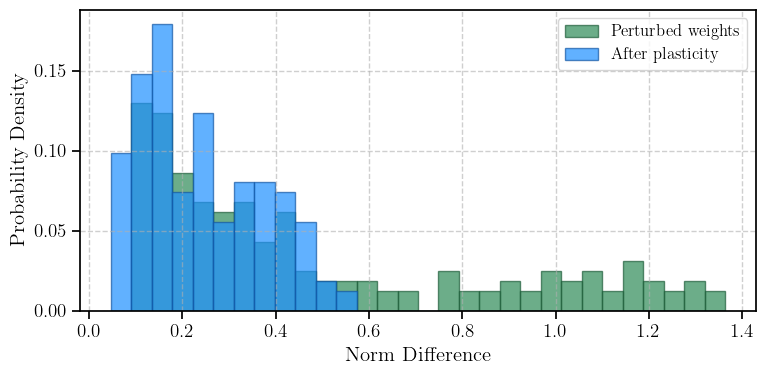

In [236]:
#EXP: look at autonomous dynamics before and after plasticity after a singular perturbation?
# Compute the differences before and after
before_diff = np.linalg.norm(xt_before[:, 0, :] - xt_before[:, -1, :], axis=1)
after_diff = np.linalg.norm(xt_after[:, 0, :] - xt_after[:, -1, :], axis=1)

# Define common bin edges
bin_min = min(before_diff.min(), after_diff.min())  
bin_max = max(before_diff.max(), after_diff.max())  
bins = np.linspace(bin_min, bin_max, 31)  # 30 equal-width bins

# Compute histogram values manually for proper normalization
before_counts, _ = np.histogram(before_diff, bins=bins)
after_counts, _ = np.histogram(after_diff, bins=bins)

# Convert counts to probability density
bin_width = bins[1] - bins[0]  # Ensure equal bin widths
before_pdf = before_counts / (before_counts.sum() )
after_pdf = after_counts / (after_counts.sum() )

# Define color palette
before_color = "#2e8b57"  # Sea Green
before_edge = "#1e5d3a"  # Darker shade of Sea Green

after_color = "#1e90ff"  # Dodger Blue
after_edge = "#1257a5"  # Darker shade of Dodger Blue

# Plot histograms with correctly normalized probability densities
plt.figure(figsize=(8, 4))
plt.bar(bins[:-1], before_pdf, width=bin_width, alpha=0.7, label='Perturbed weights', 
        color=before_color, edgecolor=before_edge, align='edge')
plt.bar(bins[:-1], after_pdf, width=bin_width, alpha=0.7, label='After plasticity', 
        color=after_color, edgecolor=after_edge, align='edge')

# Labels and formatting
plt.xlabel('Norm Difference', fontsize=15)
plt.ylabel('Probability Density', fontsize=15)
#plt.title('Probability Distribution of Activation Differences', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.tight_layout()

plt.savefig('C:/Users/abel_/Documents/Lab/Projects/topological_diversity/Stability/figures/plasticity/outer_plasticity_effect_hist.pdf', bbox_inches='tight', dpi=500)

plt.show()




In [9]:
pca = sklearn.decomposition.PCA(n_components=2)
X_proj2 = pca.fit_transform(xt_before[:,0,:]) 
all_bumps_proj2 = pca.fit_transform(all_bumps) 
corners_proj2 = pca.transform(corners)
xt_before_proj2 = pca.transform(xt_before[:,-1,:])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(N):
    ax.plot([corners_proj2[i-1,0], corners_proj2[i,0]],
            [corners_proj2[i-1,1], corners_proj2[i,1]],
            'k', label="Original attractor", zorder=0, alpha=1., linewidth=10, 
            solid_capstyle='round')
    
ax.plot(X_proj2[:,0], X_proj2[:,1], '.r', label="Stable", zorder=10, alpha=1., markersize=20)
ax.plot(xt_before_proj2[:,0], xt_before_proj2[:,1], '.g', zorder=10, alpha=1., markersize=20)


lims = 3.
ax.set(xlim=(-lims, lims), ylim=(-lims,lims))

ax.set_axis_off()
# plt.savefig(currentdir+f"/Stability/figures/noorman_ring_N{N}.pdf", bbox_inches="tight")

NameError: name 'xt_before' is not defined

## Activation function perturbation experiments

In [ ]:
output_path="C:/Users/abel_/Documents/Lab/Projects/topological_diversity/Stability/figures/plasticity/act_fun/"

#find inv man after initial pertubration for global learning rule
randomseed = 1331

pert_sols = simulate_noorman_from_y0s(all_bumps[:].T, W_sym+W_p, W_asym, c_ff=1, maxT=maxT, tsteps=tsteps)
pert_sols_proj2 = pca.transform(pert_sols.reshape(-1, N)).reshape(pert_sols.shape[0], pert_sols.shape[1], 2)